In [1]:
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras import layers
import time
import pandas as pd


def readBackFiles(folder):
    x = []
    data=pd.read_csv(folder + "gx.csv", header=None)
    check = data.isna().sum()
    if sum(check) > 0:
        raise Exception("NANs in data")
    x.append(data.values)
    x = np.dstack(x)
    y = pd.read_csv(folder + "class.csv", header=None)
    return x, y

classes = {0:"Close", 1:"Open"}

TrainFolder = "data/train/"
ValFolder = "data/val/"
TestFolder = "data/test/"

trainX,trainY = readBackFiles(TrainFolder)
trainYOneHot = tf.keras.utils.to_categorical(trainY)
print("Train")
print(trainX.shape)
print(trainY.shape)
valX,valY = readBackFiles(ValFolder)
valYOneHot = tf.keras.utils.to_categorical(valY)
print("Val")
print(valX.shape)
print(valY.shape)
print("Test")
testX,testY = readBackFiles(TestFolder)
print(testX.shape)
print(testY.shape)
testYOneHot = tf.keras.utils.to_categorical(testY)

Train
(23296, 600, 1)
(23296, 1)
Val
(56, 600, 1)
(56, 1)
Test
(70, 600, 1)
(70, 1)


In [2]:


def fitModel(model, trainX, trainY, valX, valY, epochs, batchSize, verbose,myCallbacks=None):
    model.compile(loss='categorical_crossentropy', optimizer=tf.optimizers.Adam(learning_rate=.0001),
                  metrics=['acc', "Precision", "Recall"])
    if myCallbacks == None:
        history = model.fit(trainX, trainY, epochs=epochs, batch_size=batchSize, verbose=verbose,
                            validation_data=(valX, valY))

    else:
        history = model.fit(trainX, trainY, epochs=epochs, batch_size=batchSize, verbose=verbose,
                            validation_data=(valX, valY), callbacks=myCallbacks)
    return model, history

def createModel2(xShape, yShape):
    verbose = 1
    _, timesteps, channels = xShape
    _, numCategories = yShape
    model = tf.keras.Sequential([
        layers.Conv1D(filters=64, kernel_size=8, strides=2, activation="relu", input_shape=(timesteps, channels)),
        layers.Dropout(.2),
        layers.MaxPool1D(pool_size=2),
        layers.BatchNormalization(),
        layers.Conv1D(filters=48, kernel_size=4, strides=1, activation="relu", input_shape=(timesteps, channels)),
        layers.Dropout(.2),
        layers.MaxPool1D(pool_size=2),
        layers.BatchNormalization(),
        layers.Flatten(),
        layers.Dense(768, activation="relu"),
        layers.BatchNormalization(),
        layers.Dropout(.5),
        layers.Dense(384, activation="relu"),
        layers.BatchNormalization(),
        layers.Dropout(.5),
        #layers.Dense(30, activation="relu"),
        layers.Dense(numCategories, activation="softmax")
    ])
    return model

def createModel(xShape, yShape):
    verbose = 1
    _, timesteps, channels = xShape
    _, numCategories = yShape
    model = tf.keras.Sequential([
        layers.Conv1D(filters=32, kernel_size=4, strides=2, activation="relu", input_shape=(timesteps, channels)),
        layers.Dropout(.2),
        layers.MaxPool1D(pool_size=2),
        layers.BatchNormalization(),
        layers.Conv1D(filters=24, kernel_size=2, strides=1, activation="relu", input_shape=(timesteps, channels)),
        layers.Dropout(.2),
        layers.MaxPool1D(pool_size=2),
        layers.BatchNormalization(),
        layers.Flatten(),
        layers.Dense(64, activation="relu"),
        layers.BatchNormalization(),
        layers.Dropout(.5),
        layers.Dense(32, activation="relu"),
        layers.BatchNormalization(),
        layers.Dropout(.5),
        #layers.Dense(30, activation="relu"),
        layers.Dense(numCategories, activation="softmax")
    ])
    return model

In [3]:
earlyStoppingPatience = 5 # Early stopping
reduceLRPatience = 3
epochs = 15
batchSize = 32

#BaseModelPath = "model/mymodel.h5"
BaseModelPath = "model/cp-{epoch:04d}"
earlystopping = tf.keras.callbacks.EarlyStopping(monitor="val_acc", patience=earlyStoppingPatience,restore_best_weights=False, mode="max", verbose=1)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_acc', factor=0.1,patience=reduceLRPatience, 
                              verbose=1, mode='max')
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    BaseModelPath,  verbose=1, save_best_only=False,
    save_weights_only=False, save_freq='epoch')
#myCallbacks = [reduce_lr, checkpoint]
myCallbacks = [earlystopping, reduce_lr, checkpoint]

In [4]:
!rm -rf model
!mkdir model
start = time.time()
myModel = createModel(trainX.shape, trainYOneHot.shape)
myModel, history = fitModel(myModel, trainX, trainYOneHot, valX, valYOneHot, epochs, batchSize, 2, myCallbacks)
end = time.time() - start
print("Model trainined in %d s" % end)

#numEpochsUsed = len(history.history["loss"]) - earlyStoppingPatience
#print("Trained using %d epochs" % numEpochsUsed)

Metal device set to: Apple M1 Max

systemMemory: 64.00 GB
maxCacheSize: 21.33 GB

Epoch 1/15


2022-03-22 20:04:30.716088: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-03-22 20:04:30.716236: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-03-22 20:04:30.889600: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-03-22 20:04:31.270062: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: saving model to model/cp-0001


2022-03-22 20:04:41.782367: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-22 20:04:42.191276: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: model/cp-0001/assets
728/728 - 12s - loss: 0.0698 - acc: 0.9785 - precision: 0.9785 - recall: 0.9785 - val_loss: 0.0220 - val_acc: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - lr: 1.0000e-04 - 12s/epoch - 16ms/step
Epoch 2/15

Epoch 2: saving model to model/cp-0002
INFO:tensorflow:Assets written to: model/cp-0002/assets
728/728 - 11s - loss: 0.0064 - acc: 0.9994 - precision: 0.9994 - recall: 0.9994 - val_loss: 0.0104 - val_acc: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - lr: 1.0000e-04 - 11s/epoch - 15ms/step
Epoch 3/15

Epoch 3: saving model to model/cp-0003
INFO:tensorflow:Assets written to: model/cp-0003/assets
728/728 - 11s - loss: 0.0029 - acc: 0.9998 - precision: 0.9998 - recall: 0.9998 - val_loss: 0.0058 - val_acc: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - lr: 1.0000e-04 - 11s/epoch - 14ms/step
Epoch 4/15

Epoch 4: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 4: saving model to model/c

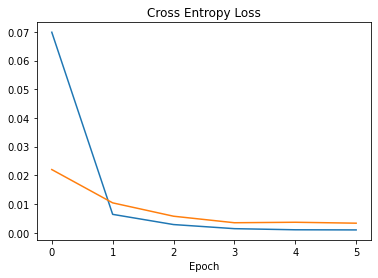

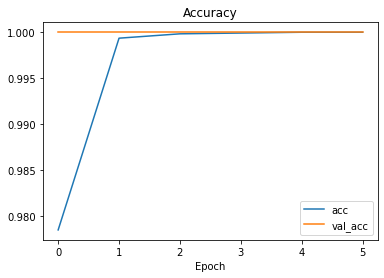

In [5]:
import matplotlib.pyplot as plt
def plotLoss(history, lossOnly=False):
    plt.figure()
    plt.title("Cross Entropy Loss")
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')

    plt.figure()
    plt.title("Accuracy")
    plt.plot(history.history['acc'], label='acc')
    plt.plot(history.history['val_acc'], label='val_acc')
    plt.xlabel('Epoch')
    plt.legend()
    
plotLoss(history)

2022-03-22 20:09:48.697066: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


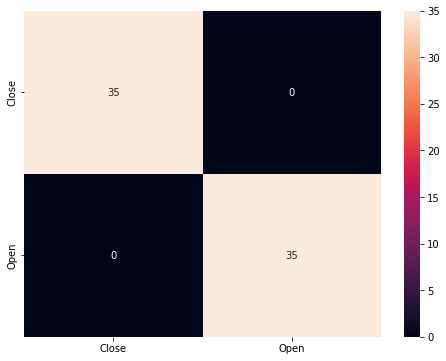

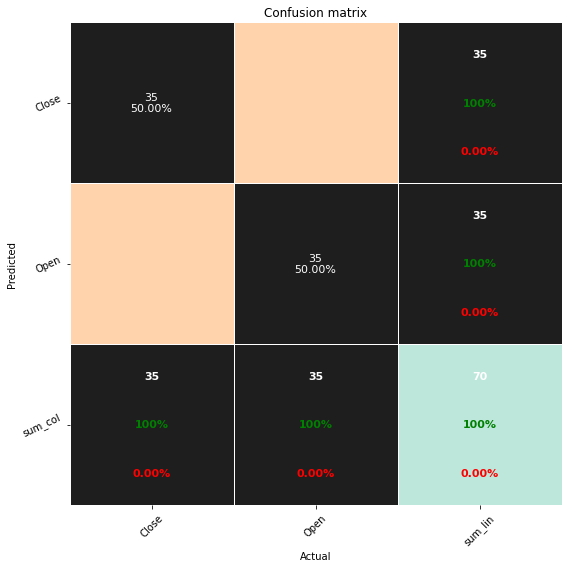

In [12]:
import pretty
import seaborn as sn
import pandas as pd

classesList = ["Close", "Open"]

def confusionPlot(y, pred, numClasses, classes, cmap="PuRd"):
    confusion = tf.math.confusion_matrix(y, pred, num_classes=numClasses)
    confusionArray = confusion.numpy()
    df_cm = pd.DataFrame(confusionArray, classes, classes)
    plt.figure(figsize=(8, 6))
    sn.heatmap(df_cm, annot=True)  # font size
    plt.xlim([0, numClasses])
    plt.ylim([numClasses, 0])
    pretty.pretty_plot_confusion_matrix(df_cm, cmap=cmap)
    plt.xlim([0, numClasses+1])
    plt.ylim([numClasses+1, 0])

myModel = tf.keras.models.load_model('model/cp-0003')
cmap = pretty.cmaps[123]
testPredRaw = myModel.predict(testX)
testPred = list(np.argmax(testPredRaw, axis=1))
confusionPlot(testY, testPred, 2, classesList, cmap)

#confusionPlot()